# Road Map

In [1]:
# steps

# get our data
    # pull the data
    # transform the data
    # recombine the data
    # get level column
    # remove any multiclass observations for now
    # remove artificer (not established data)
    # determine how to handle casting stat (categorical var) -- turn into six binary columns for each stat
    # initial simple data set will be: stats, hp, level, ac, casting stat

# EDA (exploratory data analysis)
    # distributions
    # descriptive stats
    # correlations
    # identify data issues (class labeling--complexity around structure and multiclassing, high dimensionality)
    # outlier handling -- TO DO: 
    # is the data balanced or imbalanced

# plan the model
    # identify key accuracy metrics
        # sensitivity / specificity / recall
        # true positive rate /false positive rate / f1 score, etc. 
        # confusion matrix
    # what is your success criteria?
        # what 'accuracy' do i need to achieve the ask
        # what are my constraints if any

# first pass modeling
    # really simple models
        # logistic regression
        # decision tree
        # benchmark accuracy
        
# more complex modeling
    # ensemble (random forest)
    # boosting (xgboost, adaboost)
    # feature selection (information gain, recursive feature elimination)

# model selection
    # what model best achieves our goals

# Preamble

In [2]:
# going to explore some Dungeons and Dragons character data from : https://github.com/oganm/dnddata#about-the-data
import json
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Getting data

## Pull data

In [3]:
# get the data from the github repository
url = "https://raw.githubusercontent.com/oganm/dnddata/master/data-raw/dnd_chars_all.json"

df = pd.read_json(url)

if df.shape[0] < df.shape[1]:
    df = df.transpose()

## Unpack data

In [4]:
# scrappily unpacking everything--each column comes in 2 types: jsons or singleton lists
# but dtypes only indicate if it's a python 'object' 
# drop some of the unnecessary (for us) columns, e.g. ip, finger, date, location, hash, choices
# [7803 rows x 11457 columns] when unpacking spells, drop those and weapons for now

ignore = ['ip', 'finger','date', 'location', 'hash', 'choices','weapons', 'name', 'spells']

clean_df = pd.json_normalize(df['name'])
clean_df = clean_df['alias'].str[0]

for key in df.keys():
  if key in ignore:
    continue
  try: # try doing a json_normalize, which will fail if it's not a json
    data = pd.json_normalize(df[key])
    for col in data.keys(): # unpack the singletons in each json column
      data[col] = data[col].str[0]
  except AttributeError: 
    data = df[key].str[0]
    data = data.reset_index(drop=True) # use integer index to conform with json_normalize index
  
  clean_df = pd.concat([clean_df, data], axis=1)

num_spells = df['spells'].apply(len).reset_index(drop=True)

clean_df['num_spells'] = num_spells

# remove duplicates and choose character with highest level
clean_df = clean_df.drop_duplicates(keep='first', ignore_index=True)
clean_df = clean_df.groupby('alias', group_keys=False).apply(lambda x: x.loc[x.level.idxmax()])

## Add features

In [5]:
# add generic "primary class" column based on highest level class of character
class_list = ['Artificer.level','Barbarian.level','Bard.level','Cleric.level','Druid.level','Fighter.level','Monk.level',
              'Paladin.level','Ranger.level','Rogue.level','Sorcerer.level','Warlock.level','Wizard.level']
class_df = clean_df[class_list]

primary_class = class_df.idxmax(axis=1)
class1 = list(primary_class.str.split('.').str[0])
clean_df['class1'] = class1

# add generic "primary class level" column/label
primary_class_level = class_df.max(axis=1)
clean_df['level1'] = primary_class_level

# one-hot encode castingStat
castingStat = pd.get_dummies(clean_df["castingStat"], prefix='castingStat')
clean_df = pd.concat([clean_df, castingStat], axis = 1)

# one-hot encode processedRace 
processedRace = pd.get_dummies(clean_df["processedRace"], prefix='processedRace')
clean_df = pd.concat([clean_df, processedRace], axis = 1)

# add hp / level
clean_df['hp_per_lvl'] = clean_df['HP'] / clean_df['level1']

clean_df

,alias,race,processedRace,background,Ranger.class,Ranger.subclass,Ranger.level,Rogue.class,Rogue.subclass,Rogue.level,Warlock.class,Warlock.subclass,Warlock.level,Fighter.class,Fighter.subclass,Fighter.level,Barbarian.class,Barbarian.subclass,Barbarian.level,Sorcerer.class,Sorcerer.subclass,Sorcerer.level,Paladin.class,Paladin.subclass,Paladin.level,Cleric.class,Cleric.subclass,Cleric.level,Artificer.class,Artificer.subclass,Artificer.level,Monk.class,Monk.subclass,Monk.level,Druid.class,Druid.subclass,Druid.level,Bard.class,Bard.subclass,Bard.level,...,castingStat_Str,castingStat_Wis,processedRace_,processedRace_Aarakocra,processedRace_Aasimar,processedRace_Bugbear,processedRace_Centaur,processedRace_Changeling,processedRace_Dragonborn,processedRace_Dwarf,processedRace_Eladrin,processedRace_Elf,processedRace_Firbolg,processedRace_Genasi,processedRace_Gith,processedRace_Gnome,processedRace_Goblin,processedRace_Goliath,processedRace_Half-Elf,processedRace_Half-Orc,processedRace_Halfling,processedRace_Hobgoblin,processedRace_Human,processedRace_Kalashtar,processedRace_Kenku,processedRace_Kobold,processedRace_Lizardfolk,processedRace_Loxodon,processedRace_Minotaur,processedRace_Orc,processedRace_Shifter,processedRace_Simic hybrid,processedRace_Tabaxi,processedRace_Tiefling,processedRace_Triton,processedRace_Turtle,processedRace_Vedalken,processedRace_Warforged,processedRace_Yaun-Ti,hp_per_lvl
alias,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
admiring_allen,admiring_allen,Deep Gnome,Gnome,Sage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.000000
admiring_almeida,admiring_almeida,Fire Genasi,Genasi,Cloistered Scholar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.750000
admiring_antonelli,admiring_antonelli,Tiefling,Tiefling,Mercenary Veteran,NaN,NaN,NaN,NaN,NaN,NaN,Warlock,The Great Old One,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paladin,Oath of Ancients,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.571429
admiring_archimedes,admiring_archimedes,Variant,Half-Elf,Faction Agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paladin,Oath of Ancients,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.333333
admiring_ardinghelli,admiring_ardinghelli,Lightfoot Halfling,Halfling,Sage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zen_williams,zen_williams,Mountain Dwarf,Dwarf,Clan Crafter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Barbarian,Path of the Battlerager,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.500000
zen_wing,zen_wing,Wood Elf,Elf,Acolyte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monk,Way of the Long Death,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Clean and filter data

In [6]:
# focus on only single class characters, i.e. remove multi-classes
num_classes = clean_df[class_list].apply(lambda x: x.count(), axis=1)
print('removing', len(clean_df[num_classes != 1]), 'multi-class (or zero class) entries')
no_multi_df = clean_df[num_classes == 1]

removing 676 multi-class (or zero class) entries


In [7]:
# Artificer class is a recent addition with only 60 entries--too few to reasonably train the model, ignore for now
print('removing', len(no_multi_df[no_multi_df['Artificer.level'].notnull()]), 'Artificer entries')
no_artificer_df = no_multi_df[~no_multi_df['Artificer.level'].notnull()]

removing 43 Artificer entries


In [8]:
# clean up further by removing redundant columns (with new class1 and level1 labels)
keep = ['alias',
        'background',
        'feats',
        'HP', 'AC', 'hp_per_lvl',
        'Str', 'Dex', 'Con', 'Int', 'Wis', 'Cha',
        'processedAlignment',
        'skills', 
        'class1','level1',
        'castingStat_Cha', 'castingStat_Con', 'castingStat_Dex', 'castingStat_Int',	'castingStat_Str',	'castingStat_Wis',
        'num_spells'] + [x for x in processedRace.columns]


no_artificer_df = no_artificer_df[keep]

removing 53 entries with HP / level < 2.3333333333333335 and HP / level > 16.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


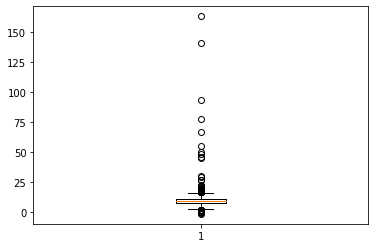

In [9]:
# HP outliers
hp_per_level = no_artificer_df['hp_per_lvl']

boxplot = plt.boxplot(hp_per_level)
whiskers = [x.get_ydata()[1] for x in boxplot['whiskers']] # gives the 1.5*iqr whisker boundaries

n_small_outliers = len(hp_per_level[hp_per_level < whiskers[0]])
n_large_outliers = len(hp_per_level[hp_per_level > whiskers[1]])
n_outliers = n_small_outliers + n_large_outliers

print(f'removing {n_outliers} entries with HP / level < {whiskers[0]} and HP / level > {whiskers[1]}')
no_artificer_df = no_artificer_df[hp_per_level >= whiskers[0]]
no_artificer_df = no_artificer_df[hp_per_level <= whiskers[1]]

In [10]:
# set main_df as primary DataFrame for modeling (lol) didn't use clean_df because it broke some of the cells below
main_df = no_artificer_df
main_df

,alias,background,feats,HP,AC,hp_per_lvl,Str,Dex,Con,Int,Wis,Cha,processedAlignment,skills,class1,level1,castingStat_Cha,castingStat_Con,castingStat_Dex,castingStat_Int,castingStat_Str,castingStat_Wis,num_spells,processedRace_,processedRace_Aarakocra,processedRace_Aasimar,processedRace_Bugbear,processedRace_Centaur,processedRace_Changeling,processedRace_Dragonborn,processedRace_Dwarf,processedRace_Eladrin,processedRace_Elf,processedRace_Firbolg,processedRace_Genasi,processedRace_Gith,processedRace_Gnome,processedRace_Goblin,processedRace_Goliath,processedRace_Half-Elf,processedRace_Half-Orc,processedRace_Halfling,processedRace_Hobgoblin,processedRace_Human,processedRace_Kalashtar,processedRace_Kenku,processedRace_Kobold,processedRace_Lizardfolk,processedRace_Loxodon,processedRace_Minotaur,processedRace_Orc,processedRace_Shifter,processedRace_Simic hybrid,processedRace_Tabaxi,processedRace_Tiefling,processedRace_Triton,processedRace_Turtle,processedRace_Vedalken,processedRace_Warforged,processedRace_Yaun-Ti
alias,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
admiring_allen,admiring_allen,Sage,NaN,7,13,7.000000,10,16,13,16,12,8,NG,Arcana,Wizard,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
admiring_almeida,admiring_almeida,Cloistered Scholar,Elemental Adept,23,12,5.750000,8,14,12,19,15,13,NN,Arcana,Wizard,4.0,0,0,0,1,0,0,19,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
admiring_archimedes,admiring_archimedes,Faction Agent,NaN,28,18,9.333333,15,12,14,10,8,17,,Athletics,Paladin,3.0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
admiring_ardinghelli,admiring_ardinghelli,Sage,NaN,46,13,4.181818,10,14,11,13,16,15,,Arcana,Wizard,11.0,0,0,0,1,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
admiring_banach,admiring_banach,Acolyte,NaN,27,17,6.750000,10,18,12,10,16,11,,Acrobatics,Monk,4.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zen_williams,zen_williams,Clan Crafter,Grappler,51,18,8.500000,19,15,18,11,11,12,LG,History,Barbarian,6.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
zen_wing,zen_wing,Acolyte,NaN,45,17,9.000000,11,19,13,13,16,11,NG,Acrobatics,Monk,5.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
zen_wozniak,zen_wozniak,Sage,War Caster,137,17,9.133333,12,19,18,21,13,13,,Arcana,Wizard,15.0,0,0,0,1,0,0,54,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Exploratory Data Analysis

## Distributions

### Number of multi-class

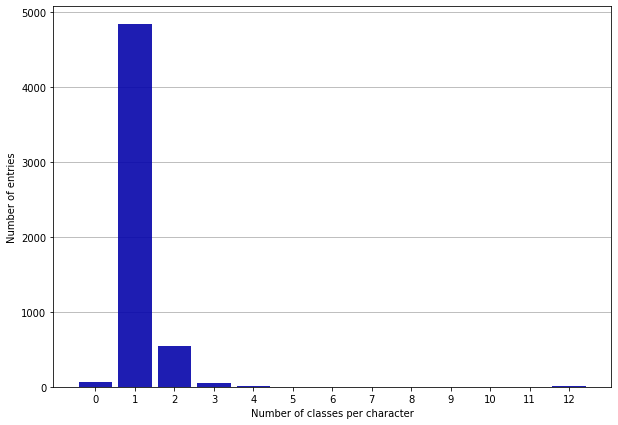

In [11]:
num_classes = clean_df[class_list].apply(lambda x: x.count(), axis=1)

fig = plt.figure(figsize=[10,7])
ax = plt.subplot(111)

ax.hist(num_classes, bins=13, range=(0,13), color='#0504aa', alpha=0.9, rwidth=0.85,align='left')
ax.yaxis.grid(True)
ax.set_axisbelow(True)
ax.set_xlabel('Number of classes per character')
ax.set_ylabel('Number of entries')

plt.xticks(np.arange(min(num_classes), max(num_classes), 1.0))
plt.show()
# there are characters with multiple class entries, although predominantly only 1-class followed by 2-class

### Class distribution

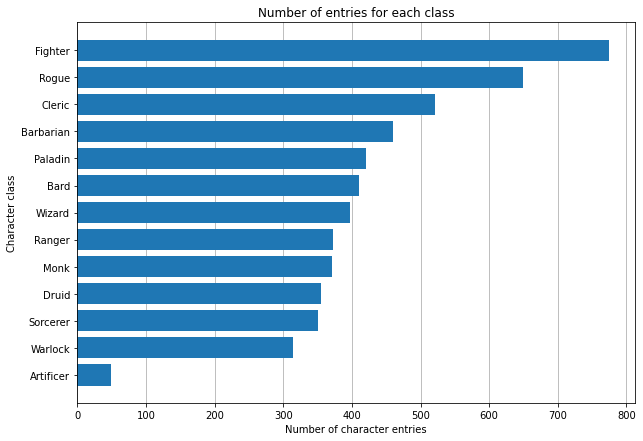

In [12]:
classes = clean_df['class1'].value_counts().index
class_counts = clean_df['class1'].value_counts().values

fig = plt.figure(figsize=[10,7])
ax = plt.subplot(111)

ax.barh(classes, class_counts)
ax.set_xlabel('Number of character entries')
ax.set_ylabel('Character class')
ax.set_title('Number of entries for each class')
ax.invert_yaxis()
ax.xaxis.grid(True)
ax.set_axisbelow(True)

### Attribute distributions

               Str          Wis  ...          Int          Dex
count  5509.000000  5509.000000  ...  5509.000000  5509.000000
mean     12.850971    13.156653  ...    12.024868    14.738791
std       4.087564     3.285545  ...     3.295140     3.266462
min       1.000000     1.000000  ...     0.000000     3.000000
25%      10.000000    11.000000  ...    10.000000    13.000000
50%      12.000000    13.000000  ...    12.000000    15.000000
75%      16.000000    15.000000  ...    14.000000    17.000000
max     103.000000   100.000000  ...    99.000000   101.000000

[8 rows x 6 columns]


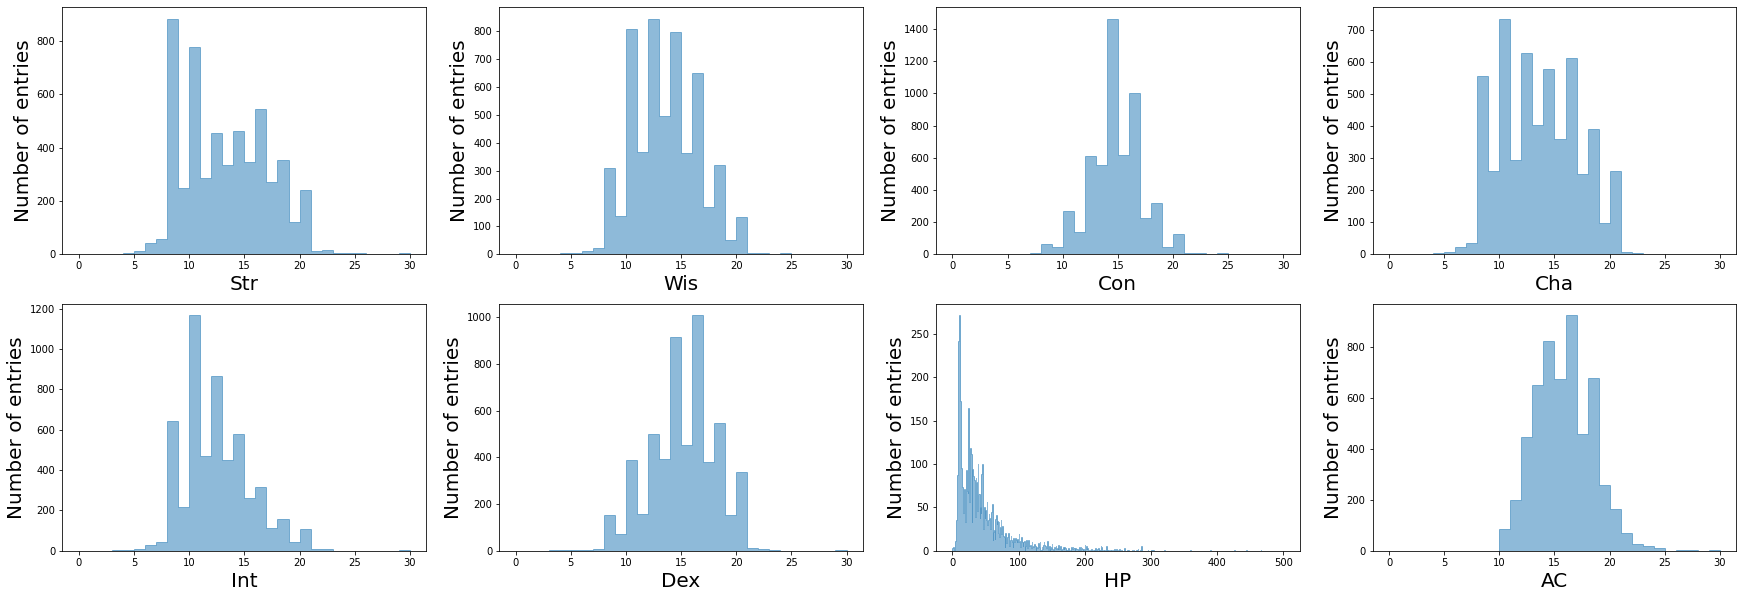

In [13]:
# get attribute data
attributes = ['Str', 'Wis', 'Con', 'Cha', 'Int', 'Dex']
attributes_data = clean_df[attributes]

print(attributes_data.describe())

if 0:
    # 2d hists
    for iattribute, attribute in enumerate(attributes):
        plt.hist(attributes_data[attribute], bins=50, range=(0,50))
        plt.xlabel(attribute)
        plt.yscale('log')
        plt.show()

        for iattribute2, attribute2 in enumerate(attributes):
            if iattribute2 > iattribute:
                plt.hist2d(attributes_data[attribute], attributes_data[attribute2], bins=50, range=[(0,50),(0,50)])
            plt.xlabel(attribute)
            plt.ylabel(attribute2)
            plt.show() 
    atts = []

    # violin plots
    for att in attributes:
        atts.append(clean_df[att])

    fig = plt.figure(figsize=[10,7])
    ax = plt.subplot(111)
    pos = [1, 2, 3, 4, 5, 6]

    ax.violinplot(atts, positions=pos, showextrema=False)
    ax.set_ylim(0,25)
    ax.set_xticks(pos)
    ax.set_xticklabels(attributes)

    # box plot
    #plt.boxplot(att_dfs, labels=attributes)
    #plt.show()
    
    # per-class histograms
    for cls in class_list:
        cls_df = clean_df[clean_df[cls].notnull()]
        atts = []
        for att in attributes:
            atts.append(cls_df[att])
        plt.hist(atts, histtype='step', fill=False, bins=30, range=(0,30))
        plt.legend(attributes)
        plt.title(cls.split('.')[0])
        plt.show()

fig, axs = plt.subplots(2,4, figsize=(30, 10))
derp = [(a,b) for a in (0,1) for b in (0,1,2,3)]
for iatt, att in enumerate(attributes + ['HP','AC']):
    n = 30
    if att == 'HP':
        n = 500
    axs[derp[iatt][0], derp[iatt][1]].hist(clean_df[att], histtype='step', fill=True, alpha=0.5, bins=n, range=(0,n))
    axs[derp[iatt][0], derp[iatt][1]].set_xlabel(att, fontsize=20)
    axs[derp[iatt][0], derp[iatt][1]].set_ylabel('Number of entries', fontsize=20)

plt.show()

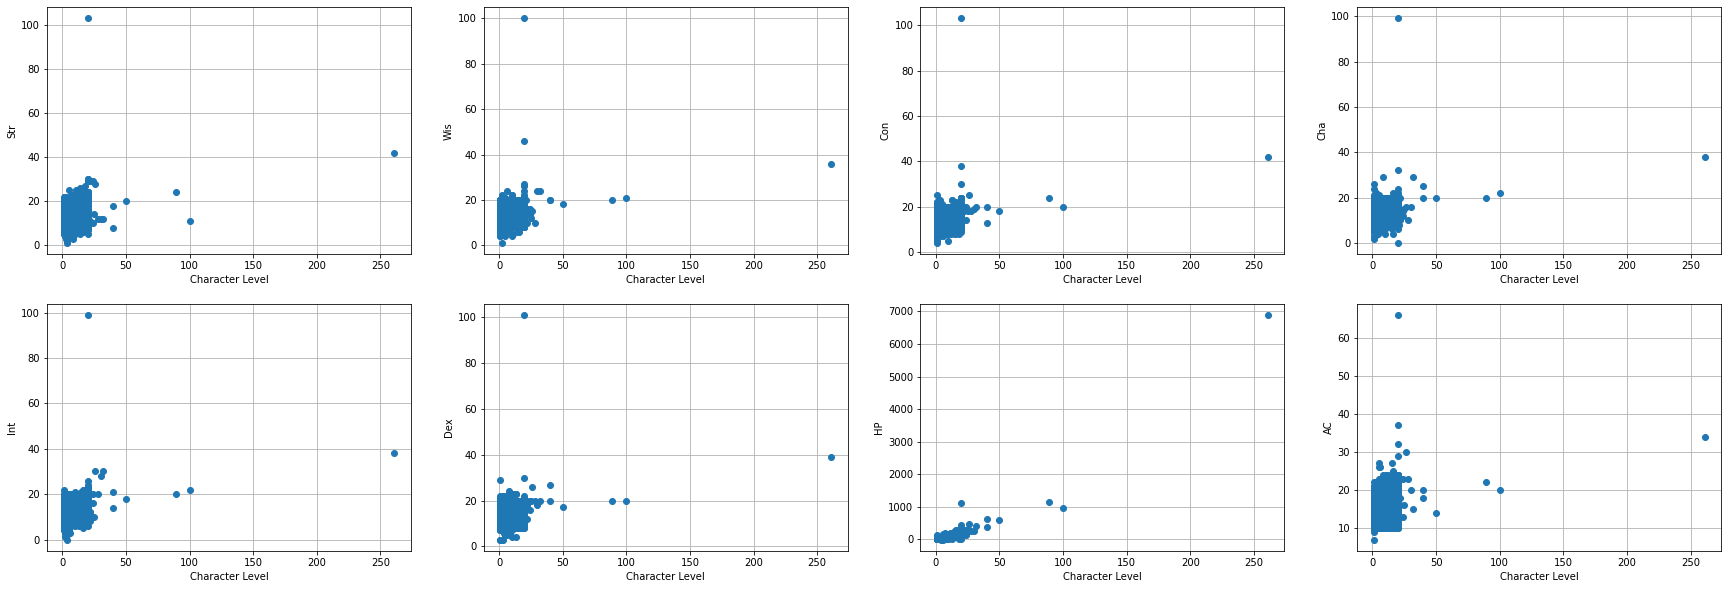

In [14]:
fig, axs = plt.subplots(2,4, figsize=(30, 10))
derp = [(a,b) for a in (0,1) for b in (0,1,2,3)]
for iatt, att in enumerate(attributes + ['HP','AC']):
    axs[derp[iatt][0], derp[iatt][1]].scatter(clean_df['level'], clean_df[att])
    axs[derp[iatt][0], derp[iatt][1]].set_xlabel('Character Level')
    axs[derp[iatt][0], derp[iatt][1]].set_ylabel(att)
    axs[derp[iatt][0], derp[iatt][1]].grid(True)
    axs[derp[iatt][0], derp[iatt][1]].set_axisbelow(True)
plt.show()

### HP distributions

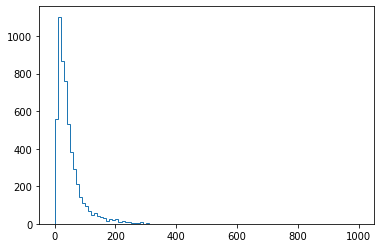

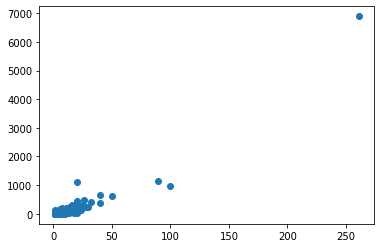

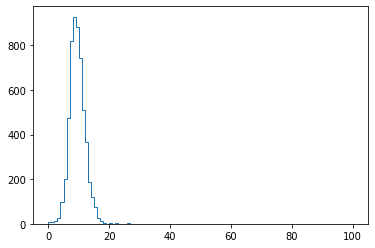

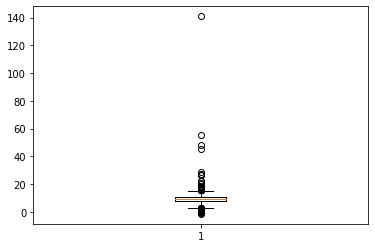

In [15]:
plt.hist(clean_df['HP'], histtype='step', fill=False, bins=100, range=(0,1000))
plt.show()

plt.scatter(clean_df['level'], clean_df['HP'])
plt.show()

# hp correlated with level, consider hp / level

hp_per_level = clean_df['HP'].divide(clean_df['level'])

plt.hist(hp_per_level, histtype='step', fill=False, bins=100, range=(0,100))
plt.show()

plt.boxplot(hp_per_level)
plt.show()

### AC distributions

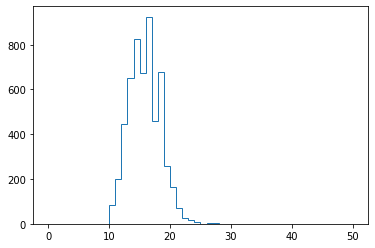

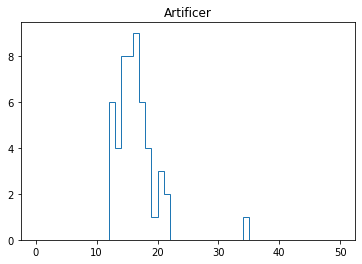

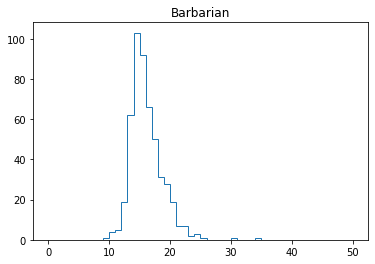

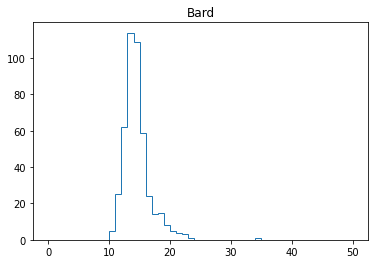

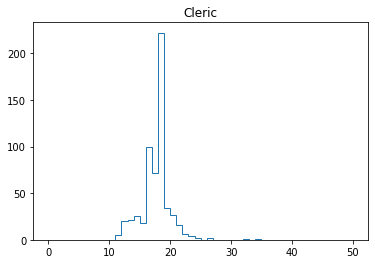

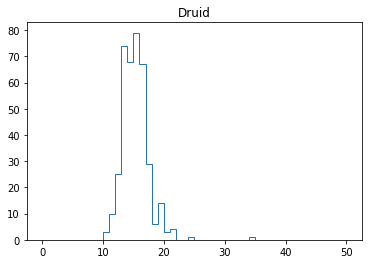

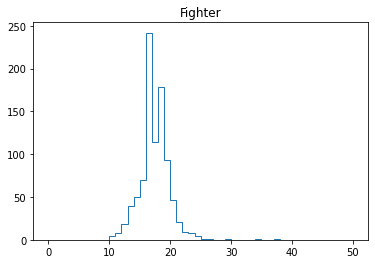

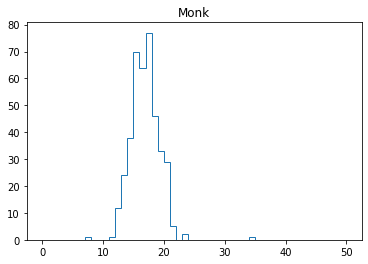

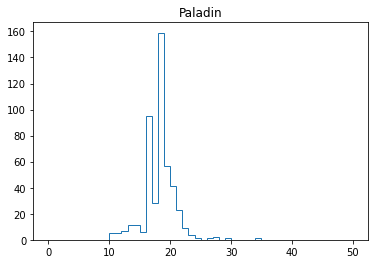

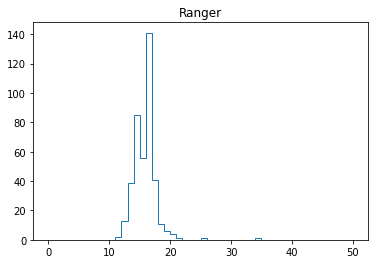

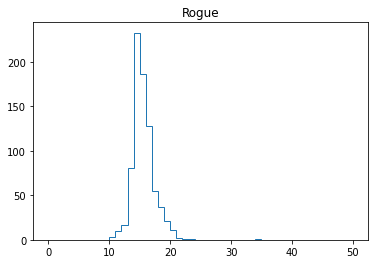

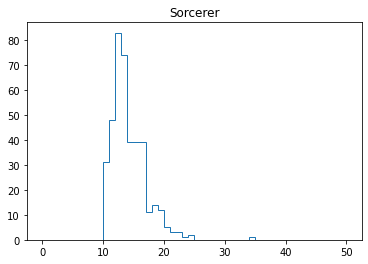

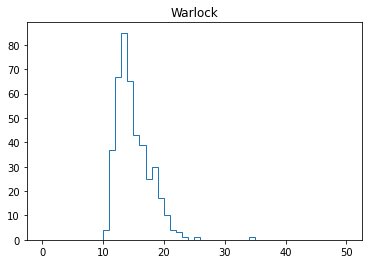

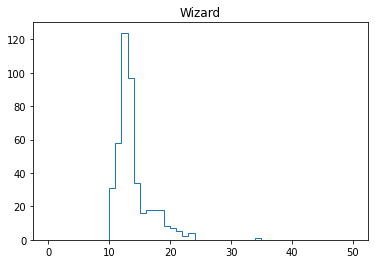

In [16]:
plt.hist(clean_df['AC'], histtype='step', fill=False, bins=50, range=(0,50))
plt.show()

# for each class
for cls in class_list:
  cls_df = clean_df[clean_df[cls].notnull()]
  plt.hist(cls_df['AC'], histtype='step', fill=False, bins=50, range=(0,50))
  plt.title(cls.split('.')[0])
  plt.show()

### Alignment distributions

count     5509
unique      10
top           
freq      3928
Name: processedAlignment, dtype: object
['NG' 'NN' '' 'CN' 'CG' 'LG' 'LE' 'LN' 'NE' 'CE']


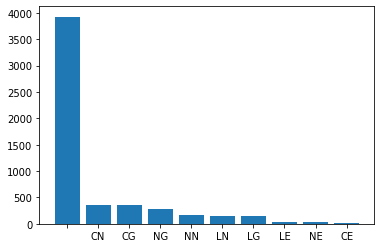

In [17]:
# get alignment data
alignment_data = clean_df['processedAlignment']

print(alignment_data.describe())
print(alignment_data.unique())

counts = alignment_data.value_counts()
plt.bar(counts.index, counts.values)
plt.show()

## Outlier Exploration

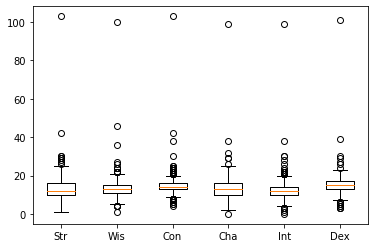

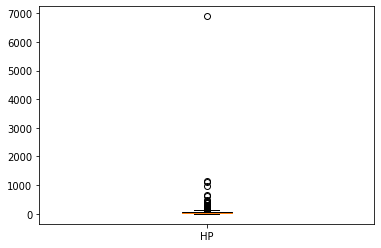

[-6.0, 124.0]


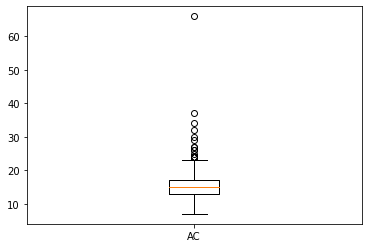

[7.0, 23.0]


In [18]:
# descriptive statistics

clean_df[ ['Str','Dex','Con','Int','Wis','Cha'] ].describe()


# distributions

# IQR / boxplot outlier analysis
att_dfs = []
for att in attributes:
  att_dfs.append(clean_df[att])

plt.boxplot(att_dfs, labels=attributes)
plt.show()

for col in "HP", "AC":
  zzz = plt.boxplot(clean_df[col], labels=[col])
  plt.show()
  x = [item.get_ydata()[1] for item in zzz['whiskers']]
  print(x)

## Correlations and Relationships

**Attributes**

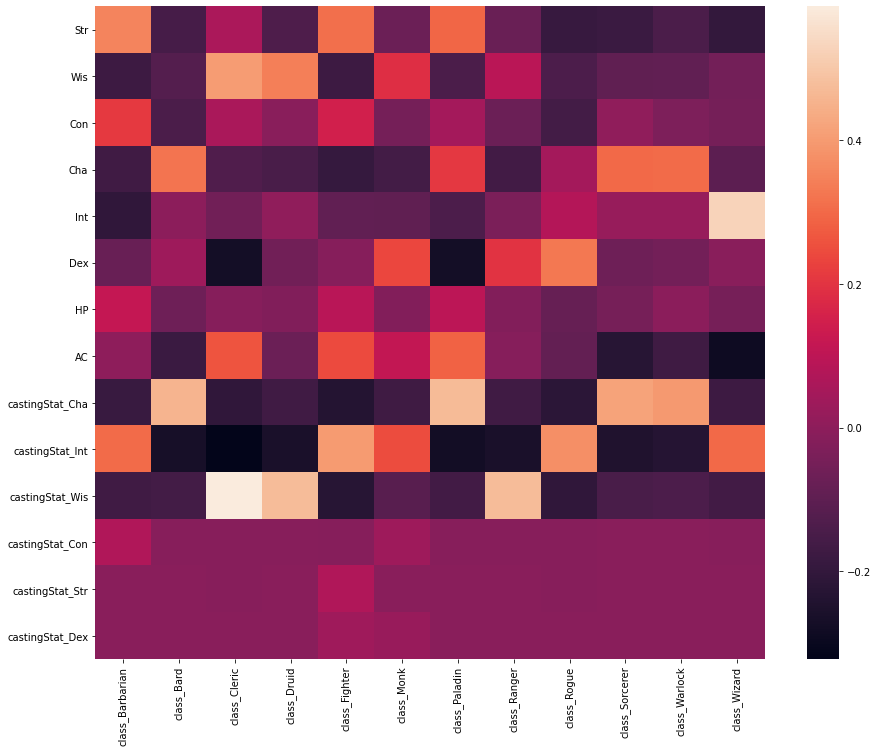

In [19]:
# to identify which features we should include or may give us info

plt.figure(figsize=(15,12))

# correlation between different attributes
# con and str seam to have a decent correlation, but the rest dont

class_type = pd.get_dummies(no_artificer_df["class1"], prefix='class')
no_artificer_df = pd.concat([no_artificer_df, class_type], axis = 1)

z = ['Barbarian', 'Bard', 'Cleric', 'Druid', 'Fighter', 'Monk', 'Paladin', 
    'Ranger', 'Rogue', 'Sorcerer', 'Warlock', 'Wizard']

classes = [f'class_{class_}' for class_ in z]
# correlation between attributes and classes
casting_stat = ['castingStat_Cha', 'castingStat_Int', 'castingStat_Wis',
                'castingStat_Con', 'castingStat_Str', 'castingStat_Dex']
att_class_cols = attributes + ['HP', 'AC'] + casting_stat + classes
att_class_df = no_artificer_df[ att_class_cols ]


att_class_corr = att_class_df.corr()
att_class_corr = att_class_corr.iloc[ 0:14, 14:]
sns.heatmap(att_class_corr)



**Armor Class**

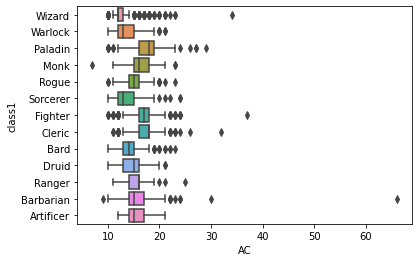

In [20]:
# let's look at armor class
ac_df = clean_df[['AC','class1']]

ax = sns.boxplot(x="AC", y="class1", data=ac_df)

(0.9248693864005879, 0.0)
0.9248693864005886


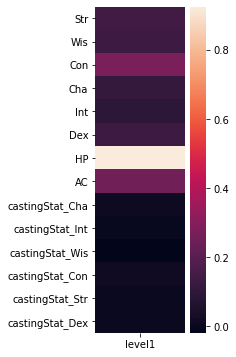

In [21]:
plt.figure(figsize=(2,6))

att_class_cols = attributes + ['HP', 'AC'] + casting_stat + ['level1']
att_class_df = no_artificer_df[ att_class_cols ]

att_class_corr = att_class_df.corr()
att_class_corr = att_class_corr.iloc[ 0:14, 14:]

sns.heatmap(att_class_corr)

from scipy.stats.stats import pearsonr
print(pearsonr(att_class_df['HP'], att_class_df['level1']))
print(np.corrcoef(att_class_df['HP'], att_class_df['level1'])[0, 1])

# Model Planning

In [22]:
# what will success look like
 # define the set to which your model can be applied (aka single class characters)
 # build models optimizing for both acc and f1 score--how do they compare?

 # Success would look like: Can correctly identify class of single class character with 80% TPR, and <5% FPR

# what will our accuracy metrics be?
  # TPR, FPR, PPV

# Building a model:
  # Pick what algorithm we want to use
  # determine any issues / concerns associated with the model, things we should watch out for
  # split our data into test/train
  # train the model using k fold cross validation
    # all on training set
  # look at accuracy metrics (i.e. tpr/fpr, confusion matrix, recall, precision)
    # all needs to be done on the test set
  # investigate model behavior -- taking a deeper look
  


# Binary Classifiers

## Run when doing binary model

In [23]:
def make_ROC_curve(fpr, tpr, roc_auc):
    fig = plt.figure(figsize=[10,7])
    ax = plt.subplot(111)

    ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    x_ticks = np.arange(0, 11, 1)
    plt.xticks(x_ticks / 10.)
    plt.show()

In [24]:
# we can do 1vsAll (will lead to class imbalance)
# could only build model on 2 classes in data
# we could generalize classes to spellcasters/not spell casters (1/0)

# to do this, need a new is_spellcaster column
# Bard, Druid, Wizard, Cleric, Sorcerer, Warlock
spellcasters = ['Bard','Cleric','Druid','Sorcerer','Warlock','Wizard']

main_df['is_spellcaster'] = main_df['class1'].isin(spellcasters).astype(int)

# check balance between spellcaster and not-spellcaster
print(main_df.groupby('is_spellcaster').count()['AC'])

attributes = ['Str','Dex','Con','Int','Wis','Cha']
castingStat = [f'castingStat_{attribute}' for attribute in attributes]
features = ['AC', 'hp_per_lvl'] + attributes + castingStat
X = main_df[ features ]
y = main_df['is_spellcaster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# check balance between training and test set
print(y_train.groupby(y_train).size())
print(y_test.groupby(y_test).size())

is_spellcaster
0    2651
1    2086
Name: AC, dtype: int64
is_spellcaster
0    2003
1    1549
Name: is_spellcaster, dtype: int64
is_spellcaster
0    648
1    537
Name: is_spellcaster, dtype: int64


## Binary Logistic Regression

In [25]:
# logistic regression without CV
clf = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

print('training accuracy ', clf.score(X_train, y_train))
print('testing accuracy ', clf.score(X_test, y_test))

# logistic regression with CV
clf = LogisticRegressionCV(cv = 10, random_state=42, solver='liblinear').fit(X_train, y_train)
print('training accuracy ', clf.score(X_train, y_train))
print('testing accuracy ',clf.score(X_test, y_test))

training accuracy  0.8961148648648649
testing accuracy  0.8852320675105485
training accuracy  0.8963963963963963
testing accuracy  0.8877637130801688


In [26]:
# use f1 scoring
clf = LogisticRegressionCV(cv = 10, random_state=42, solver='liblinear', scoring = 'f1').fit(X_train, y_train)
print('training f1 score: ', clf.score(X_train, y_train))
print('testing f1 score: ', clf.score(X_test, y_test))

y_pred = clf.predict(X_test)

print('\nConfusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred))
print('')

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print('TPR: ', tp / (tp+fn))
print('FPR: ', fp / (fp+tn))

training f1 score:  0.8813668600902644
testing f1 score:  0.876279069767442

Confusion Matrix:
[[581  67]
 [ 66 471]]

TPR:  0.8770949720670391
FPR:  0.10339506172839506


[[9.99389262e-01 6.10737761e-04]
 [4.77696671e-01 5.22303329e-01]
 [9.58822225e-01 4.11777747e-02]
 ...
 [4.97056019e-04 9.99502944e-01]
 [9.99982112e-01 1.78877608e-05]
 [4.18377597e-02 9.58162240e-01]]
[6.10737761e-04 5.22303329e-01 4.11777747e-02 ... 9.99502944e-01
 1.78877608e-05 9.58162240e-01]


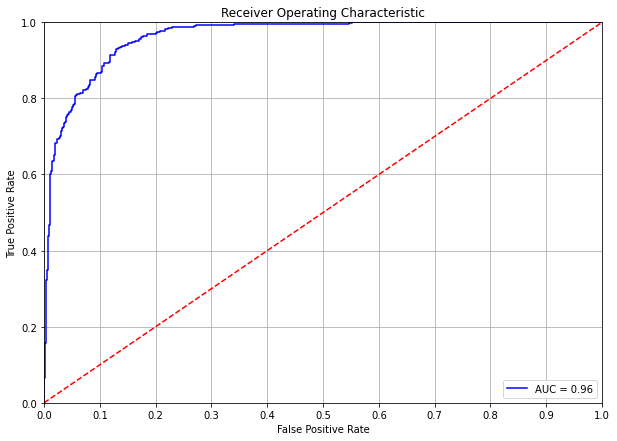

[]


In [27]:
# generate a ROC curve to see if we can change decision boundary to enhance results
# calculate the fpr and tpr for all thresholds of the classification

# probabilities of being in each class
probs = clf.predict_proba(X_test)
print(probs)

# extract probability observation is class 1
preds = probs[:,1]
print(preds)

# 3 arrays with fpr, tpr, threshold for given thresholds
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

make_ROC_curve(fpr, tpr, roc_auc)

print([z for z in zip(threshold, fpr, tpr) if z[1] < 0.05 and z[2] > 0.80])

# looks like we can get to our goal with any of the following (threshold, fpr, tpr)
# (0.6809461260594947, 0.047619047619047616, 0.8017902813299232), 
# (0.6780313746306711, 0.049783549783549784, 0.8017902813299232), 
# (0.6766166948962654, 0.049783549783549784, 0.8043478260869565)

## Binary Decision Tree

In [28]:
# let's check out decision tree
# risks: overfitting, offset with hyperparameters

# use same training / testing data
clf = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 25, min_samples_leaf= 20)
clf = clf.fit(X_train, y_train)

print('training ACC', clf.score(X_train, y_train))
print('testing ACC', clf.score(X_test, y_test))

training ACC 0.9366554054054054
testing ACC 0.9080168776371308


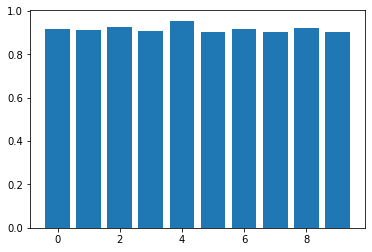

mean f1 score of 10-fold cv: 0.915, (std: 0.015)


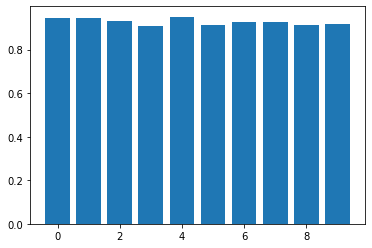

mean f1 score of 10-fold cv: 0.928, (std: 0.015)


In [29]:
# https://scikit-learn.org/stable/modules/grid_search.html#model-specific-cross-validation
# DT doesn't have a dedicated CV function like LogisticRegressionCV

# perform 10-fold cv and print the f1 score for each fold
clf = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 25, min_samples_leaf= 20)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_macro')
plt.bar(range(len(scores)), scores)
plt.show()
print(f'mean f1 score of 10-fold cv: {scores.mean():.3f}, (std: {scores.std():.3f})')

if 0: # this takes awhile to run, change to 1 if you want to play with it
  # hyperparameter tuning with grid search
  param_grid = {"criterion": ['gini', 'entropy'],
                "max_depth": [None, 5, 10, 20],
                "min_samples_leaf": [1, 5, 10, 20],
                "min_samples_split": [2, 5, 10, 20]
                }

  dt = tree.DecisionTreeClassifier()

  grid_search = GridSearchCV(dt, param_grid=param_grid, cv=10, scoring='f1')
  grid_search.fit(X_train, y_train)
  print('Best parameters: ', grid_search.best_params_)
  print('Resulting best score:', grid_search.best_score_)
  # result: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10}

# perform 10-fold cv and print the f1 score for each fold using optimized hyperparameters
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, min_samples_leaf= 5, min_samples_split=10)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_macro')
plt.bar(range(len(scores)), scores)
plt.show()
print(f'mean f1 score of 10-fold cv: {scores.mean():.3f}, (std: {scores.std():.3f})')

In [30]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, min_samples_leaf= 5, min_samples_split=10)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred))
print('')

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print('TPR: ', tp / (tp+fn))
print('FPR: ', fp / (fp+tn))

Confusion Matrix:
[[608  40]
 [ 55 482]]

TPR:  0.8975791433891993
FPR:  0.06172839506172839


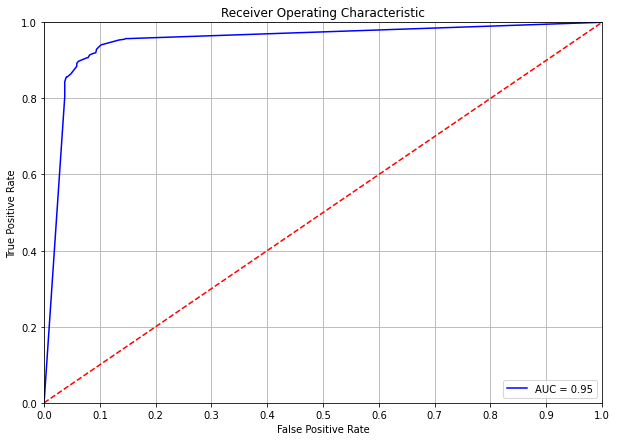

[(1.0, 0.037037037037037035, 0.8044692737430168), (0.875, 0.037037037037037035, 0.8156424581005587), (0.8333333333333334, 0.037037037037037035, 0.8342644320297952), (0.8235294117647058, 0.037037037037037035, 0.8435754189944135), (0.8, 0.038580246913580245, 0.851024208566108), (0.75, 0.040123456790123455, 0.8566108007448789), (0.7272727272727273, 0.041666666666666664, 0.8566108007448789), (0.6666666666666666, 0.047839506172839504, 0.8640595903165735)]


In [31]:
# use a single decision tree to calculate probabilities

probs = clf.predict_proba(X_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

make_ROC_curve(fpr, tpr, roc_auc)

print([z for z in zip(threshold, fpr, tpr) if z[1] < 0.05 and z[2] > 0.80])
# definitely satisfy the tpr > 80%, fpr < 5% success metric for a range of thresholds
# specific threshold depends on if you want to prioritize cranking up tpr or suppressing fpr

# Multi-class Classifier

## Run when doing multi-class model

In [32]:
# new target column using the entire multiclass 
attributes = ['Str','Dex','Con','Int','Wis','Cha']
castingStat = [f'castingStat_{attribute}' for attribute in attributes]
features = ['AC', 'hp_per_lvl'] + attributes + castingStat

X = main_df[ features ]
y = main_df['class1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(y_train.groupby(y_train).size())
print(y_test.groupby(y_test).size())

class1
Barbarian    298
Bard         264
Cleric       358
Druid        244
Fighter      486
Monk         257
Paladin      281
Ranger       257
Rogue        424
Sorcerer     221
Warlock      196
Wizard       266
Name: class1, dtype: int64
class1
Barbarian     94
Bard          83
Cleric       124
Druid         87
Fighter      176
Monk          81
Paladin       88
Ranger        73
Rogue        136
Sorcerer      73
Warlock       76
Wizard        94
Name: class1, dtype: int64


## Multi-class Logistic Regression

In [33]:
clf = LogisticRegression(random_state=42, solver='liblinear', multi_class='auto').fit(X_train, y_train)

print('training accuracy ', clf.score(X_train, y_train))
print('testing accuracy ', clf.score(X_test, y_test))

# Accuracy measurements
y_pred = clf.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, digits=3))

# probabilities of being in each class
probs = clf.predict_proba(X_test)
print(probs)

# extract probability observation is class 1
preds = probs[:,1]
print(preds)

training accuracy  0.7378941441441441
testing accuracy  0.7257383966244726
[[ 71   0   0   0  21   0   0   0   0   0   0   2]
 [  0  56   0   0   0   0   2   0   0  19   6   0]
 [  0   0 101  11   0   0   0  12   0   0   0   0]
 [  0   0  18  61   0   1   0   7   0   0   0   0]
 [ 21   0   0   0 120   4   1   0  27   0   0   3]
 [  4   0   1   1   7  47   0   4  17   0   0   0]
 [  0   3   0   0   0   0  84   0   0   1   0   0]
 [  0   0   7   4   0   0   0  62   0   0   0   0]
 [  1   0   0   0   4   7   0   1 113   0   0  10]
 [  0  16   0   0   0   0   2   0   0  49   6   0]
 [  0  34   0   1   0   1   6   0   0  23  10   1]
 [  0   0   0   0   2   0   0   0   6   0   0  86]]
              precision    recall  f1-score   support

   Barbarian      0.732     0.755     0.743        94
        Bard      0.514     0.675     0.583        83
      Cleric      0.795     0.815     0.805       124
       Druid      0.782     0.701     0.739        87
     Fighter      0.779     0.682     0.7

## Multi-class Decision Tree

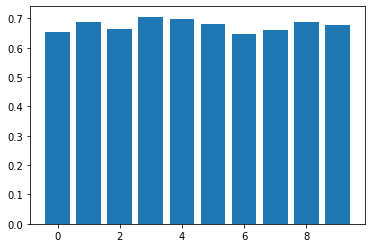

mean f1 score of 10-fold cv: 0.677, (std: 0.018)


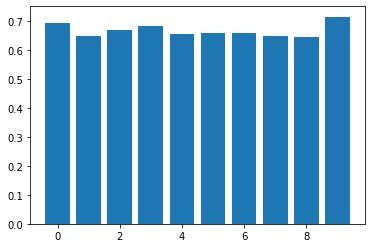

mean f1 score of 10-fold cv: 0.669, (std: 0.022)


In [34]:
clf = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 25, min_samples_leaf= 20)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_macro')
plt.bar(range(len(scores)), scores)
plt.show()
print(f'mean f1 score of 10-fold cv: {scores.mean():.3f}, (std: {scores.std():.3f})')

if 0: # this takes awhile to run, change to 1 if you want to play with it
  # hyperparameter tuning with grid search
  param_grid = {"criterion": ['gini', 'entropy'],
                "max_depth": [None, 5, 10, 20],
                "min_samples_leaf": [1, 5, 10, 20],
                "min_samples_split": [2, 5, 10, 20]
                }

  dt = tree.DecisionTreeClassifier()

  grid_search = GridSearchCV(dt, param_grid=param_grid, cv=10, scoring='f1_macro')
  grid_search.fit(X_train, y_train)
  print('Best parameters: ', grid_search.best_params_)
  print('Resulting best score:', grid_search.best_score_)
 
# perform 10-fold cv and print the f1 score for each fold using optimized hyperparameters
clf = tree.DecisionTreeClassifier(random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_macro')
plt.bar(range(len(scores)), scores)
plt.show()
print(f'mean f1 score of 10-fold cv: {scores.mean():.3f}, (std: {scores.std():.3f})')

In [35]:
clf = tree.DecisionTreeClassifier(random_state=42)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Confusion Matrix')
print(metrics.confusion_matrix(y_test, y_pred))
print('')
print('Success Metrics')
print(metrics.classification_report(y_test, y_pred, digits=3))

Confusion Matrix
[[ 70   0   0   0  18   2   0   0   3   0   0   1]
 [  0  42   0   0   0   0   3   0   0  15  23   0]
 [  0   0 106   7   0   3   1   7   0   0   0   0]
 [  0   0  22  55   0   1   0   9   0   0   0   0]
 [ 25   0   0   0 119   8   1   0  19   0   0   4]
 [  3   0   2   0  11  39   0   2  21   0   0   3]
 [  0   5   0   0   1   0  75   0   0   4   3   0]
 [  0   0   5  12   0   1   0  55   0   0   0   0]
 [  1   0   1   0  17  13   0   0  95   0   0   9]
 [  0  12   0   0   0   0   2   0   0  43  16   0]
 [  0  27   1   0   0   1   5   0   1  22  18   1]
 [  3   0   0   0   3   1   0   0   4   0   0  83]]

Success Metrics
              precision    recall  f1-score   support

   Barbarian      0.686     0.745     0.714        94
        Bard      0.488     0.506     0.497        83
      Cleric      0.774     0.855     0.812       124
       Druid      0.743     0.632     0.683        87
     Fighter      0.704     0.676     0.690       176
        Monk      0.565     

###Feature Importance

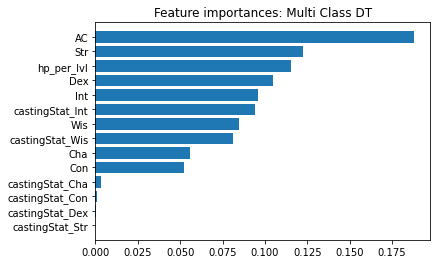

In [36]:
# feature importance for multiclass decision tree
importance = clf.feature_importances_

# combine list of features and importance weights into dataframe
importance_dt = zip(list(X_train.columns), importance)
importance_dt = set(importance_dt)
importance_dt = pd.DataFrame(importance_dt, columns = ['feature','importance'])

# sort dataframe to graph from high to low
importance_dt = importance_dt.sort_values('importance',ascending = True)
importance_dt.reset_index(drop = True)

# plot the feature weights
plt.figure()
plt.title("Feature importances: Multi Class DT")
plt.barh(range(importance_dt.shape[0]), width = importance_dt['importance'], align="center")
plt.yticks(range(importance_dt.shape[0]), importance_dt['feature'])
plt.ylim([-1, importance_dt.shape[0]])
plt.show()

## Support Vector Machine

### Linear SVM

In [37]:
# bring in some libraries to do scaling and svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.svm import SVC

# create classifier by first scaling the data (mean 0 sd 1) and then putting into linear SVM
# SVM does better if features are scaled as it is not scale invariant
clf = make_pipeline(StandardScaler(), SVC(kernel = 'linear'))
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(metrics.confusion_matrix(y_test, y_pred))

print(metrics.classification_report(y_test, y_pred, digits=3))

[[ 68   0   0   0  24   0   0   0   1   0   0   1]
 [  0  52   0   0   1   0   1   0   0  19  10   0]
 [  0   0  99  14   0   0   0  11   0   0   0   0]
 [  0   0  14  67   0   0   0   6   0   0   0   0]
 [ 26   0   0   0 122   5   1   0  22   0   0   0]
 [  1   0   2   1   9  49   0   1  18   0   0   0]
 [  0   5   0   0   0   0  80   0   0   1   2   0]
 [  0   0   5   4   0   0   0  64   0   0   0   0]
 [  1   0   0   0   6   9   0   1 112   0   0   7]
 [  0  11   0   0   0   0   0   0   0  49  13   0]
 [  0  31   0   1   0   1   5   0   0  22  15   1]
 [  0   0   0   0   1   0   0   0   6   0   0  87]]
              precision    recall  f1-score   support

   Barbarian      0.708     0.723     0.716        94
        Bard      0.525     0.627     0.571        83
      Cleric      0.825     0.798     0.811       124
       Druid      0.770     0.770     0.770        87
     Fighter      0.748     0.693     0.720       176
        Monk      0.766     0.605     0.676        81
     Pal

### Grid Search on SVM

In [38]:
# let's scale the data since it doesn't like the pipeline in grid search
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

In [39]:
# lets do a grid search instead of going through all different kernels, etc.

if 0: # this takes awhile to run, change to 1 if you want to play with it
  # hyperparameter tuning with grid search
  param_grid = {"kernel": ['linear', 'rbf','poly','sigmoid'],
                "degree": [2,3,4],
                "decision_function_shape": ['ovr','ovo']
                
                }

  clf = SVC()

  grid_search = GridSearchCV(clf, param_grid=param_grid, cv=10, scoring='f1_macro')
  grid_search.fit(X_train_scaled, y_train)
  print('Best parameters: ', grid_search.best_params_)
  print('Resulting best score:', grid_search.best_score_)

In [40]:
# now let's build with those parameters
clf = make_pipeline(StandardScaler(), SVC(kernel = 'rbf', degree = 2, decision_function_shape = 'ovr'))
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(metrics.confusion_matrix(y_test, y_pred))

print(metrics.classification_report(y_test, y_pred, digits=3))

[[ 69   0   0   0  24   0   0   0   0   0   0   1]
 [  0  51   0   0   0   0   3   0   0  18  11   0]
 [  0   0 102  10   0   0   0  12   0   0   0   0]
 [  0   0  11  67   0   0   0   9   0   0   0   0]
 [ 23   0   0   0 130   4   1   0  17   0   0   1]
 [  4   0   3   1   8  48   0   1  16   0   0   0]
 [  0   4   0   0   0   0  81   0   0   2   1   0]
 [  0   0   4   4   0   0   0  65   0   0   0   0]
 [  1   0   1   0   7   9   0   0 114   0   0   4]
 [  0  18   0   0   0   0   0   0   0  44  11   0]
 [  0  33   0   1   0   1   6   0   0  20  14   1]
 [  0   0   0   0   1   1   0   0   3   0   0  89]]
              precision    recall  f1-score   support

   Barbarian      0.711     0.734     0.723        94
        Bard      0.481     0.614     0.540        83
      Cleric      0.843     0.823     0.833       124
       Druid      0.807     0.770     0.788        87
     Fighter      0.765     0.739     0.751       176
        Monk      0.762     0.593     0.667        81
     Pal

## XGBoost

In [41]:
# to really understand this we will need to study gradient descent
import xgboost

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
y_encoded = label_encoder.transform(y)

X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.25, random_state=42)

model = xgboost.XGBClassifier(random_state=42)
model.fit(X_train, y_train)
print(model)

y_pred = model.predict(X_test)

print(metrics.confusion_matrix(y_test, y_pred))

print(metrics.classification_report(y_test, y_pred, digits=3))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
[[ 70   0   0   0  24   0   0   0   0   0   0   0]
 [  0  51   0   0   0   0   5   0   0  14  13   0]
 [  0   0 106  11   0   1   0   6   0   0   0   0]
 [  0   0   9  68   0   0   0  10   0   0   0   0]
 [ 22   0   0   0 132   5   1   0  13   0   0   3]
 [  4   0   1   1   6  50   0   2  14   0   0   3]
 [  0   4   0   0   0   0  81   0   0   2   1   0]
 [  0   0   4   4   0   0   0  65   0   0   0   0]
 [  1   0   1   0   7  11   0   0 110   0   0   6]
 [  0  16   0   0   0   0   1   0   0  48   8   0]
 [  0  29   0   1   

In [42]:
# xgboost doesn't improve upon DT, despite being a slightly more refined approach
# might be running into a 'wall' of what information can be extracted from these features and they are not discriminative
# enough to distinguish Bard, Warlock, and Sorcerer

main_df.groupby('class1')['num_spells'].describe()

spells_per_level = main_df['num_spells'].divide(main_df['level1'])
main_df['spells_per_lvl'] = spells_per_level

print(main_df.groupby('class1')['num_spells'].describe())

print(main_df.groupby('class1')['spells_per_lvl'].describe())


features = ['AC', 'hp_per_lvl', 'spells_per_lvl'] + attributes + castingStat
X = main_df[ features ]

X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.25, random_state=42)

model = xgboost.XGBClassifier(random_state=42)
model.fit(X_train, y_train)
print(model)

y_pred = model.predict(X_test)

print(metrics.confusion_matrix(y_test, y_pred))

print(metrics.classification_report(y_test, y_pred, digits=3))

           count       mean        std  min  25%  50%   75%   max
class1                                                           
Barbarian  392.0   0.073980   0.419641  0.0  0.0  0.0   0.0   3.0
Bard       347.0   4.089337   5.584410  0.0  0.0  0.0   8.0  30.0
Cleric     482.0  10.207469  10.441128  2.0  4.0  8.0  12.0  94.0
Druid      331.0   5.271903   8.857376  0.0  0.0  1.0   8.0  98.0
Fighter    662.0   0.572508   1.832642  0.0  0.0  0.0   0.0  15.0
Monk       338.0   0.150888   0.661140  0.0  0.0  0.0   0.0   6.0
Paladin    369.0   4.203252   4.693820  0.0  0.0  4.0   6.0  27.0
Ranger     330.0   1.806061   2.635731  0.0  0.0  0.0   3.0  15.0
Rogue      560.0   0.580357   1.864067  0.0  0.0  0.0   0.0  12.0
Sorcerer   294.0   5.255102   5.809803  0.0  0.0  3.5  10.0  24.0
Warlock    272.0   5.470588   7.701959  0.0  0.0  2.0   8.0  53.0
Wizard     360.0   8.186111  10.931864  0.0  0.0  1.0  13.0  56.0
           count      mean       std  min  25%       50%       75%   max
cla

## Random Forests

In [43]:
# add new spells/level feature
main_df['spells_per_lvl'] = main_df['num_spells'].divide(main_df['level1'])
features = ['AC', 'hp_per_lvl', 'spells_per_lvl'] + attributes + castingStat
X = main_df[features]
y = main_df['class1']
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.25, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print('Confusion Matrix')
print(metrics.confusion_matrix(y_test, y_pred))
print('')
print('Success Metrics')
print(metrics.classification_report(y_test, y_pred, digits=3))

Confusion Matrix
[[ 70   0   0   0  24   0   0   0   0   0   0   0]
 [  0  50   0   0   0   0   2   0   0  12  19   0]
 [  0   0 112  10   0   0   0   2   0   0   0   0]
 [  0   0  12  67   0   0   0   8   0   0   0   0]
 [ 14   0   0   0 139   6   1   0  15   0   0   1]
 [  5   0   0   1   8  55   0   1  11   0   0   0]
 [  0   3   0   0   0   0  83   0   0   1   1   0]
 [  0   0   4   3   0   0   0  66   0   0   0   0]
 [  1   0   0   0  11   8   0   0 109   0   0   7]
 [  0  15   0   0   0   0   2   0   0  54   2   0]
 [  0  26   0   1   0   1   5   0   0  15  27   1]
 [  0   0   0   0   1   0   0   0   3   0   0  90]]

Success Metrics
              precision    recall  f1-score   support

   Barbarian      0.778     0.745     0.761        94
        Bard      0.532     0.602     0.565        83
      Cleric      0.875     0.903     0.889       124
       Druid      0.817     0.770     0.793        87
     Fighter      0.760     0.790     0.774       176
        Monk      0.786     

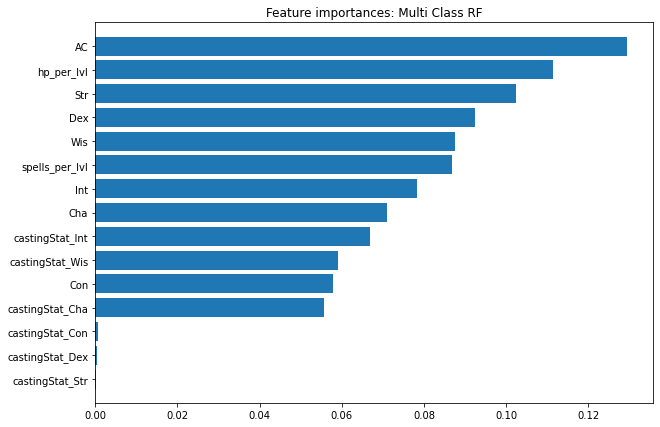

In [44]:
# feature importance for multiclass Random Forest
importance = clf.feature_importances_

# combine list of features and importance weights into dataframe
importance_rf = zip(list(X_train.columns), importance)
importance_rf = set(importance_rf)
importance_rf = pd.DataFrame(importance_rf, columns = ['feature','importance'])

# sort dataframe to graph from high to low
importance_rf = importance_rf.sort_values('importance',ascending = True)
importance_rf.reset_index(drop = True)

# plot the feature weights
fig = plt.figure(figsize=[10,7])
ax = plt.subplot(111)
plt.title("Feature importances: Multi Class RF")
plt.barh(range(importance_rf.shape[0]), width = importance_rf['importance'], align="center")
plt.yticks(range(importance_rf.shape[0]), importance_rf['feature'])
plt.ylim([-1, importance_rf.shape[0]])
plt.show()

In [45]:
y = main_df[main_df['is_spellcaster'] == 1]
z = y[y['num_spells'] > 0]
print(z)

print(pearsonr(z['num_spells'], z['level1']))
print(np.corrcoef(z['num_spells'], z['level1'])[0, 1])


                                     alias  ... spells_per_lvl
alias                                       ...               
admiring_almeida          admiring_almeida  ...       4.750000
admiring_ardinghelli  admiring_ardinghelli  ...       1.909091
admiring_benz                admiring_benz  ...       2.400000
admiring_chatterjee    admiring_chatterjee  ...       1.000000
admiring_elgamal          admiring_elgamal  ...       2.000000
...                                    ...  ...            ...
zen_kowalevski              zen_kowalevski  ...       2.562500
zen_moore                        zen_moore  ...       3.000000
zen_newton                      zen_newton  ...       0.200000
zen_pascal                      zen_pascal  ...       0.066667
zen_wozniak                    zen_wozniak  ...       3.600000

[1329 rows x 62 columns]
(0.4417191880985949, 1.406165403128951e-64)
0.4417191880985948


# Evaluating model on own DnD characters

In [46]:
my_char = pd.DataFrame({'AC': [12],
                        'hp_per_lvl': [17 / 2.],
                        'spells_per_lvl': [6 / 2.],
                        'Str': [6],
                        'Dex': [13],
                        'Con': [14],
                        'Int': [13],
                        'Wis': [15],
                        'Cha': [20],
                        'castingStat_Str': [0],
                        'castingStat_Dex': [0],
                        'castingStat_Con': [0],
                        'castingStat_Int': [0],
                        'castingStat_Wis': [0],
                        'castingStat_Cha': [1]})
print(clf.predict(my_char))

['Warlock']


In [47]:
other_char_string = """
Character Name,Class,Level,AC,hp,hp_per_lvl,spells,spells_per_lvl,Str,Dex,Con,Int,Wis,Cha,Casting Stat
grimlock,druid,8,16,67,8.375,14,1.75,8,14,16,10,20,12,Wis
inspector cruso,cleric,8,20,74,9.25,16,2,11,15,18,14,18,13,Wis
locke,rogue,8,16,66,8.25,0,0,11,18,17,14,14,20,Int
miek the murderbot,fighter,8,17,80,10,0,0,12,18,16,12,16,13,Int
farrow,monk,10,21,95,9.5,0,0,11,20,16,16,20,14,Wis
"""

from io import StringIO

other_chars = pd.read_csv(StringIO(other_char_string))

for cstat in castingStat:
  stat = cstat.split('_')[1]
  derp = other_chars['Casting Stat'] == stat
  other_chars[f'{cstat}'] = derp.astype(int)


test_other_chars = other_chars.drop(['Character Name', 'Class', 'Level', 'hp', 'spells', 'Casting Stat'], axis=1)
print(clf.predict(test_other_chars))

fighter = other_chars[other_chars['Class'] == 'fighter']
fighter = fighter.drop(['Character Name', 'Class', 'Level', 'hp', 'spells', 'Casting Stat'], axis=1)

probs = clf.predict_proba(fighter)
print(probs)

['Druid' 'Cleric' 'Rogue' 'Monk' 'Monk']
[[0.   0.   0.   0.   0.14 0.83 0.   0.   0.03 0.   0.   0.  ]]
